In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


    # OLS
import statsmodels.api as sm
    # ML Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

    # Pipeline & Preprocess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

    # Scores
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , r2_score
from sklearn.metrics import mean_absolute_percentage_error

#### Run Helpers

In [2]:
%run '../Helpers/Data_Process.py'
%run '../Helpers/Models.py'
%run '../Helpers/Data_visualisation.py'

### Data

In [5]:
df = pd.read_csv('../Data/df_Toulouse_appartement_vf.csv',low_memory=False)

In [6]:
dfm = pd.read_csv('../Data/df_Toulouse_maison_vf.csv',low_memory=False)

In [7]:
list_dist_metro_dummies = []
for i in range(0,df.shape[0]):
    if df['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (df['dist_metro'].iloc[i] <= 500) & (df['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (df['dist_metro'].iloc[i] > 500) & (df['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
df['dist_metro_dummies'] = list_dist_metro_dummies

### OLS

In [8]:
#dummies_pr_var_continues(df, 'dist_metro', 200)
dummies_pr_var_continues(df, 'Nombre_dependance', 0)
dummies_pr_var_continues(df, 'Ec_maternelle', 0)
dummies_pr_var_continues(df, 'Ec_elementaire', 0)

In [9]:
df_train = df[df['date_mutation'] < '2021-04-01']
df_test = df[df['date_mutation'] >= '2021-04-01']

In [10]:
df_train = pd.concat([df_train, pd.get_dummies(df_train[['quarter']])], axis = 1)

In [11]:
df_train['n_pieces_BienStandard'] = df_train['nombre_pieces_principales']-3
df_train['n_dependances_BienStandard'] = df_train['Nombre_dependance']

In [12]:
features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

In [13]:
model = model_OLS_prix(df_train, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     142.4
Date:                Sun, 02 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:17:17   Log-Likelihood:            -1.6238e+05
No. Observations:               19709   AIC:                         3.248e+05
Df Residuals:                   19692   BIC:                         3.249e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

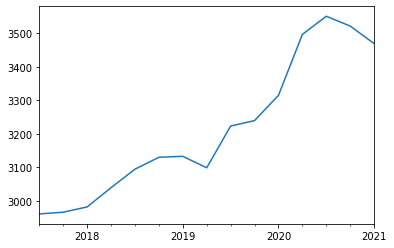

In [14]:
df_train = add_indice_prix(df_train, indice_prix_quarter(model, plot = True))

### KNN

In [15]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train = 'Prix_m2_actualise_Q1_2021'
label_test = 'Prix_m2'

In [16]:
knn_pipe = model_KNN_coordinates(df_train, df_test, features_knn,
                          label_train, label_test,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 23}


In [17]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe, df_train[features_knn], df_train[label_train])

MAPE:  11.589403301592382
MDAPE:  9.145257573447289


In [18]:
    # Scores on TEST dataset
compute_scores(knn_pipe, df_test[features_knn], df_test[label_test])

MAPE:  12.08485738488736
MDAPE:  10.242775367593355


### RF

In [19]:
features_RF = [#'Nombre_dependance', 
               'Nombre_dependance', 'dist_metro',
               #'dist_metro', 
               'nombre_pieces_principales',
               #'Ec_elementaire', 'Ec_maternelle',
               'Ec_elementaire', 'Ec_maternelle',
               'N_apparts', 
               'DISP_MED19', 
               'Part_chomeurs', 
               #'P19_LOG','P19_RP_SDB','P19_RP_CCCOLL',
               #'P19_RP_CCIND','P19_RP_CINDELEC'
]

In [20]:
RF_model = model_RF_post_KNN(df_test, df_train, features_RF, features_knn, label_train, label_test,
                      model_knn = knn_pipe, standardisation = StandardScaler(), range_depth = [1, 1000], nb_cv = 5)

In [21]:
X_train_rf = df_train[features_RF]
X_train_rf['y_pred_knn'] = knn_pipe.predict(df_train[features_knn])
X_test_rf = df_test[features_RF]
X_test_rf['y_pred_knn'] = knn_pipe.predict(df_test[features_knn])
compute_scores(RF_model, X_test_rf, df_test[label_test])

MAPE:  11.817103687804734
MDAPE:  9.815316206206123


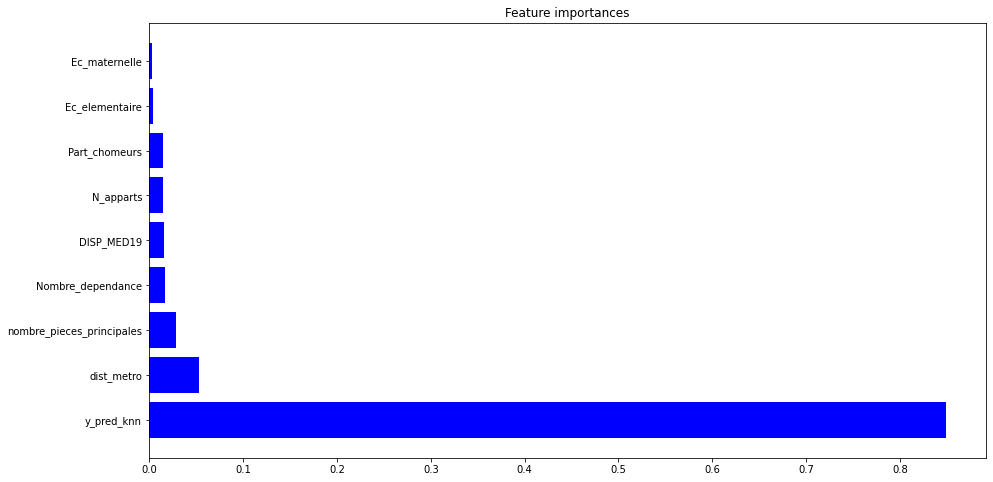

In [22]:
RF_importances = RF_model.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances, X_train_rf)

In [23]:
pipe = Pipeline([('scaler', StandardScaler()), ('GBoost', GradientBoostingRegressor())])
parameters = {'GBoost__n_estimators': [50, 100, 150, 250, 500]} # defining parameter space
gboost_pipe = GridSearchCV(pipe, parameters, cv=5)
gboost_pipe.fit(X_train_rf, df_train[label_train])

compute_scores(gboost_pipe, X_test_rf, df_test[label_test])

MAPE:  11.790295957018673
MDAPE:  9.904328389301787


### Maison

### OLS

In [24]:
#dummies_pr_var_continues(dfm, 'dist_metro', 0.01)
dummies_pr_var_continues(dfm, 'Nombre_dependance', 0)
dummies_pr_var_continues(dfm, 'Ec_maternelle', 0)
dummies_pr_var_continues(dfm, 'Ec_elementaire', 0)

df_train_m = dfm[dfm['date_mutation'] < '2021-04-01']
df_test_m = dfm[dfm['date_mutation'] >= '2021-04-01']

df_train_m = pd.concat([df_train_m, pd.get_dummies(df_train_m[['quarter']])], axis = 1)
df_train_m['n_pieces_BienStandard'] = df_train_m['nombre_pieces_principales']- 4 #4c'est le nombre le plus frequent
df_train_m['n_dependances_BienStandard'] = df_train_m['Nombre_dependance']

features_ols = ['quarter_2017_Q4', 'quarter_2018_Q1', 'quarter_2018_Q2', 'quarter_2018_Q3',
'quarter_2018_Q4', 'quarter_2019_Q1', 'quarter_2019_Q2',
'quarter_2019_Q3', 'quarter_2019_Q4', 'quarter_2020_Q1','quarter_2020_Q2', 
'quarter_2020_Q3', 'quarter_2020_Q4','quarter_2021_Q1',
'n_pieces_BienStandard', 'n_dependances_BienStandard']
outcome = 'Prix_m2'

list_dist_metro_dummies = []
for i in range(0,dfm.shape[0]):
    if dfm['dist_metro'].iloc[i] <= 200 :
        a = 0
    elif (dfm['dist_metro'].iloc[i] <= 500) & (dfm['dist_metro'].iloc[i] > 200) :
        a = 1
    elif (dfm['dist_metro'].iloc[i] > 500) & (dfm['dist_metro'].iloc[i] <= 1000) :
        a = 2
    else:
        a = 3
    list_dist_metro_dummies.append(a)
dfm['dist_metro_dummies'] = list_dist_metro_dummies


In [25]:
model_m = model_OLS_prix(df_train_m, 'Prix_m2', features_ols, summary = True)

                            OLS Regression Results                            
Dep. Variable:                Prix_m2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.966
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           3.28e-10
Time:                        21:19:18   Log-Likelihood:                -19152.
No. Observations:                2336   AIC:                         3.834e+04
Df Residuals:                    2319   BIC:                         3.844e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

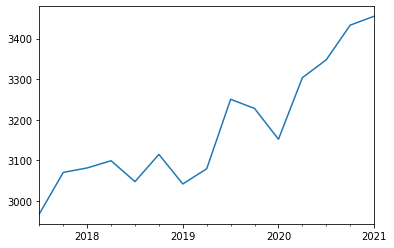

In [26]:
df_train_m = add_indice_prix(df_train_m, indice_prix_quarter(model_m, plot = True))

### KNN

In [40]:
    # Dependant variables : cooridnates
features_knn = ['latitude', 'longitude']
    # Output
label_train_m  = 'Prix_m2_actualise_Q1_2021'
label_test_m   = 'Prix_m2'

knn_pipe_m = model_KNN_coordinates(df_train_m, df_test_m, features_knn,
                          label_train_m, label_test_m,
                          MinMaxScaler(), 'uniform', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 9}


In [28]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe_m, df_train_m[features_knn], df_train_m[label_train])

MAPE:  13.038484336994777
MDAPE:  9.721214998290776


In [31]:
    # Scores on TEST dataset
compute_scores(knn_pipe_m, df_test_m[features_knn], df_test_m[label_test])

MAPE:  13.692739237676943
MDAPE:  10.938316272248416


In [41]:
knn_pipe_m_distance = model_KNN_coordinates(df_train_m, df_test_m, features_knn,
                          label_train_m, label_test_m,
                          MinMaxScaler(), 'distance', 25, 5)

Returned hyperparameter: {'Knn__n_neighbors': 13}


In [42]:
    # Scores on TRAIN dataset
compute_scores(knn_pipe_m_distance, df_train_m[features_knn], df_train_m[label_train])

MAPE:  1.1261338763083255
MDAPE:  0.0


In [46]:
    # Scores on TEST dataset
compute_scores(knn_pipe_m_distance, df_test_m[features_knn], df_test_m[label_test])

MAPE:  13.647884600385773
MDAPE:  10.854386821482828


### RF

In [54]:
features_RF_m = [#'Nombre_dependance', 
               'Nombre_dependance', 'dist_metro',
               #'dist_metro', 
               'nombre_pieces_principales',
               #'Ec_elementaire', 'Ec_maternelle',
               'Ec_elementaire_dummy', 'Ec_maternelle_dummy',
               'N_apparts', 
               'DISP_MED19', 
               'Part_chomeurs', 
               #'P19_LOG','P19_RP_SDB','P19_RP_CCCOLL',
               #'P19_RP_CCIND','P19_RP_CINDELEC'
]

In [55]:
RF_model_m = model_RF_post_KNN(df_test_m, df_train_m, features_RF_m, features_knn, label_train_m, label_test_m,
                      model_knn = knn_pipe_m, standardisation = StandardScaler(), range_depth = [20, 40, 60], nb_cv = 5)


In [56]:
X_train_rf_m = df_train_m[features_RF_m]
X_train_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_train_m[features_knn])
X_test_rf_m = df_test_m[features_RF_m]
X_test_rf_m['y_pred_knn'] = knn_pipe_m.predict(df_test_m[features_knn])
compute_scores(RF_model_m, X_test_rf_m, df_test_m[label_test_m])

MAPE:  14.48906827010559
MDAPE:  11.649408824069894


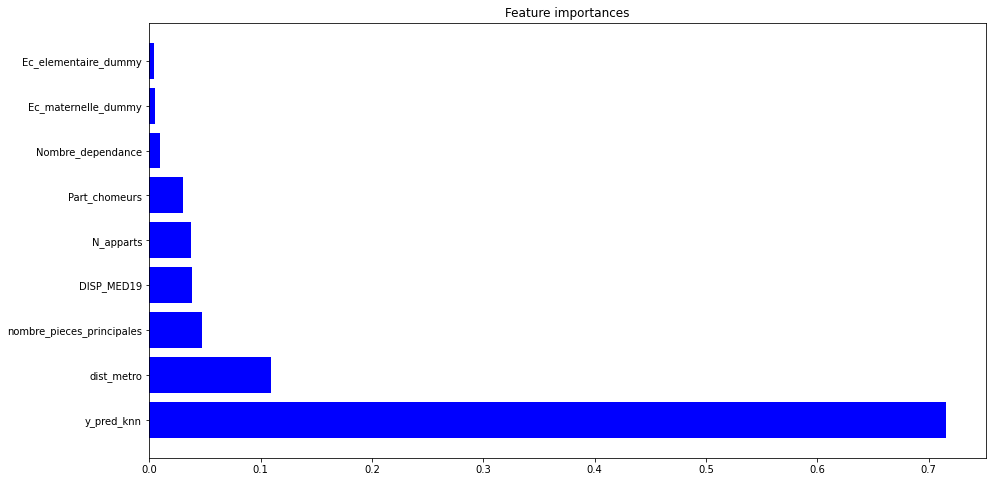

In [57]:
RF_importances_m = RF_model_m.best_estimator_.named_steps["RForest"].feature_importances_
features_importances(RF_importances_m, X_train_rf_m)